## Noise Robust Speaker Region Identification

 - zheng94@g.ucla.edu 
 - zilaiwang2001@g.ucla.edu
 - kangrui@g.ucla.edu

how to run this code:
1. Ctrl+F to search for the key word 'path' to find five places that need to change.
2. use new file path to load datasets and run all code.

**Declaration: we don't use any test dataset either clean or noisy to train the encoders, we split the training set for training and evaluation.**

package versions:

In [15]:
print("torch:", torch.__version__)
print("librosa:", librosa.__version__)
print("torchaudio:", torchaudio.__version__)
print("numpy:", np.__version__)
print("xgboost:", xgboost.__version__)
print("shap:", shap.__version__)
print("pandas:", pd.__version__)
print("opensmile:", opensmile.__version__)
print("soundfile:", sf.__version__)

torch: 2.2.0
librosa: 0.10.1
torchaudio: 2.2.0
numpy: 1.23.5
xgboost: 2.0.3
shap: 0.44.1
pandas: 2.0.3
opensmile: 2.5.0
soundfile: 0.12.1


generated feature files for XGB classifier:

@44HZ_train_mfcc_dnn.csv 
@44HZ_test_clean_mfcc_dnn.csv 
@44HZ_test_noisy_mfcc_dnn.csv



In [5]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.__version__)

True
4
0
NVIDIA GeForce RTX 2080 Ti
2.2.0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
import python_speech_features
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import random
import xgboost
import shap
import pandas as pd
import opensmile
import torch
import soundfile as sf


In [16]:
class Extractor():

    def mfcc_feature(audio_file, n_mfcc=39, resample=False):

        '''
        Function to extract mfcc features from a single audio file given its path
        '''

        audio ,fs = torchaudio.load(audio_file)
        audio = audio.numpy().reshape(-1)

        if resample:
            audio = librosa.resample(audio, orig_sr=44100, target_sr=16000)

        mfcc = []
        mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_mfcc)

        mfccs = mfccs.T
        
        ### calculate the mfcc feature of each 10 frames
        
        ### To solve the cpu memory problem, classify the audio to 4 classes
        if len(mfccs)<1000:
            for i in range (0,len(mfccs)-11,10):
                t = np.mean(mfccs[i:i+11],axis=0)
                mfcc.append(t.tolist())
                feat_out = torch.tensor(mfcc) 
        

        elif len(mfccs)>=1000 and len(mfccs)<2000:
            for i in range (0,len(mfccs)-21,20):
                t = np.mean(mfccs[i:i+21],axis=0)
                mfcc.append(t.tolist())
                feat_out = torch.tensor(mfcc) 


        elif len(mfccs)>=2000 and len(mfccs)<3000:
            for i in range (0,len(mfccs)-31,30):
                t = np.mean(mfccs[i:i+31],axis=0)
                mfcc.append(t.tolist())
                feat_out = torch.tensor(mfcc) 

        
        else:
            for i in range (0,len(mfccs),len(mfccs)//100):
                t = np.mean(mfccs[i:i+len(mfccs)//100],axis=0)
                mfcc.append(t.tolist())
                feat_out = torch.tensor(mfcc)

        return feat_out
    
    
    def smile_feature(wav, resample=False):
        '''
        Function to extract smile feature
        '''
        audio,sample_fs = torchaudio.load(wav)

        sample_audio = audio.numpy().reshape(-1)

        smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.GeMAPSv01b,
            feature_level=opensmile.FeatureLevel.Functionals,
        )

        y = smile.process_signal(
            sample_audio,
            sample_fs
        )
        
        return torch.tensor(y.iloc[0])

        

    def get_label(file_name):
        '''
        Function to retrieve output labels from filenames
        '''
        if 'ROC' in file_name:
            label=0
        elif 'LES' in file_name:
            label=1
        elif 'DC' in file_name:
            label=2
        elif 'PRV' in file_name:
            label=3
        elif 'VLD' in file_name:
            label=4
        else:
            raise ValueError('invalid file name')
        
        return label
    


In [8]:
### Training data Loading # path
train_files = glob('new dataset path')

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat=[]
train_label=[]

for wav in tqdm(train_files):
  
  train_feat.append(Extractor.mfcc_feature(wav,resample=False)) # Down Sample to 16KHZ
  train_label.append(Extractor.get_label(wav))

# data padding
train_feat = pad_sequence(train_feat, batch_first=True)
train_label = torch.tensor(train_label, dtype=torch.long)


  0%|          | 2/4372 [00:00<06:09, 11.82it/s]

100%|██████████| 4372/4372 [08:53<00:00,  8.20it/s]


In [9]:
###Testing in clean data loading # path
test_clean_files = glob('new dataset path')

test_clean_files.sort()

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(Extractor.mfcc_feature(wav,resample=False)) #Down Sample to 16KHZ
  test_clean_label.append(Extractor.get_label(wav))

# data padding
test_clean_feat = pad_sequence(test_clean_feat, batch_first=True)
test_clean_label = torch.tensor(test_clean_label, dtype=torch.long)

  0%|          | 0/447 [00:00<?, ?it/s]

100%|██████████| 447/447 [00:52<00:00,  8.56it/s]


In [10]:
###test data loading in noisy # path
test_noisy_files = glob('new dataset path')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat.append(Extractor.mfcc_feature(wav,resample=False))
  test_noisy_label.append(Extractor.get_label(wav))

# data padding
test_noisy_feat = pad_sequence(test_noisy_feat, batch_first=True)
test_noisy_label = torch.tensor(test_noisy_label, dtype=torch.long)

100%|██████████| 347/347 [00:44<00:00,  7.77it/s]


In [17]:
def same_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
### fix the random seed
same_seeds(9)

# data API
class DataProcessing():
    def flatten_data(data):
        flattened_tensor = data.view(len(data), -1)
        
        return flattened_tensor #Debugging
    
    def shuffle_data(self, data, label):
        global train_loader, test_loader, train_feat_loader

        dataset = TensorDataset(data.to(device), label.to(device))

        # shuffle this is very important because we sorted before:
        indices = np.arange(len(dataset))
        np.random.shuffle(indices)
        shuffled_dataset = [dataset[i] for i in indices]
        train_size = int(0.8 * len(shuffled_dataset))
        eval_size = len(shuffled_dataset) - train_size

        # split the dataset
        train_dataset, eval_dataset = torch.utils.data.random_split(shuffled_dataset, [train_size, eval_size])

        # create DataLoader 
        # we split the train data with ratio 8:2 for train and evaluation
        # train_loader:test_loader = 8:2
        # train_loader + test_loader = train_feat_loader (for evaluation)
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        test_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False) #eval_dataset
        train_feat_loader = DataLoader(dataset, batch_size=128, shuffle=False) #dataset
        
        return None
    
    def loader_data(self, data, label):
        global loader
        dataset = TensorDataset(data.to(device), label.to(device))
        loader = DataLoader(dataset, batch_size=10, shuffle=False)
        
        return None
    
    def softmax(self, Z):
        '''
        function for calculate stable softmax
        '''
        # Subtract the maximum value along the last axis for numerical stability
        Z = torch.exp(Z - torch.max(Z, dim=-1, keepdim=True)[0])
        
        # Calculate softmax along the last axis
        return Z / torch.sum(Z, dim=-1, keepdim=True)
    
    
###Three kinds of encoders
class DNN_Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DNN_Encoder, self).__init__()
        self.seq_len = None
        
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 32)
        self.layer3 = nn.Linear(32, 16)
        self.out = nn.Linear(16, output_dim)
        
        self.act_fn = nn.ReLU()
        self.dropout = nn.Dropout(p=0.15)
        
    

    def forward(self, x):
        self.seq_len = len(x[0])
        x = self.layer1(x)
        x = self.act_fn(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.act_fn(x)

        x = self.layer3(x)
        x = self.act_fn(x)
        x = self.dropout(x)

        x = self.out(x)
        
        x = torch.mean(x,axis=1) #make sequence equal to one
        return x


class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(),
            #nn.Dropout(p=0.3)
        )

    def forward(self, x):
        x = self.block(x)
        return x


class LSTM_Encoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=1, hidden_dim=128):
        super(LSTM_Encoder, self).__init__()
        self.input_size = input_dim
        self.hidden_size = 128
        self.num_layers = 6 
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        self.fc = nn.Sequential(
            BasicBlock(2 * self.hidden_size, hidden_dim),
             *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers-1)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x, _ = self.rnn(x)
        #x = torch.mean(x,axis=1)
        x = x[:, -1]
        x = self.fc(x)
        return x
        
    

class MultiheadSelfAttention_Encoder(nn.Module):
    def __init__(self, num_heads, dim_q, dim_k, dim_v):
        super(MultiheadSelfAttention_Encoder, self).__init__()
        self.num_heads = num_heads
        self.dim_q = dim_q
        self.dim_k = dim_k
        self.dim_v = dim_v

        # Linear transformations for query, key, and value vectors for each head
        self.linear_q = nn.Linear(dim_q, num_heads * dim_k, bias=False)
        self.linear_k = nn.Linear(dim_q, num_heads * dim_k, bias=False)
        self.linear_v = nn.Linear(dim_q, num_heads * dim_v, bias=False)

        # Final linear transformation to project concatenated outputs of all heads
        self.linear_out = nn.Linear(num_heads * dim_v, dim_v)

        self._norm_fact = 1 / (dim_k ** 0.5)

    def forward(self, x, mask=None):
        batch, seq_length, dim_q = x.shape
        assert dim_q == self.dim_q

        # Linear transformations for query, key, and value vectors
        q = self.linear_q(x)
        k = self.linear_k(x)
        v = self.linear_v(x)

        # Reshape to separate heads
        q = q.view(batch, seq_length, self.num_heads, self.dim_k)
        k = k.view(batch, seq_length, self.num_heads, self.dim_k)
        v = v.view(batch, seq_length, self.num_heads, self.dim_v)

        # Transpose to prepare for batch matrix multiplication
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Calculate scaled dot-product attention scores
        score = torch.matmul(q, k.transpose(-2, -1)) * self._norm_fact

        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        # Apply softmax along the last dimension
        score = torch.softmax(score, dim=-1)

        # Apply attention to value vectors
        att = torch.matmul(score, v)

        # Transpose and reshape the output
        att = att.transpose(1, 2).contiguous().view(batch, seq_length, -1)

        # Final linear transformation
        att = self.linear_out(att)
        
        att = torch.mean(att,axis=1)

        return att



###################################################################
'''
# Hyperparameters for LSTM 
input_dim = 39  ###try 39 dim mfcc feature as example
output_dim = 5 
lr = 0.001
num_epochs = 18
'''

# Hyperparameters for DNN
input_dim = 39  ### try 39 dim mfcc feature as example/ 62 dim onpensmile feature
output_dim = 5
lr = 0.001
num_epochs = 20
#batch_size = 4


'''
#Hyperparameters for Multihead Self-attention
num_heads = 8
dim_q = 39  # dimension of query (input_dim)
dim_k = 20
dim_v = 5
lr = 0.001
num_epochs = 10
'''

'''
# Hyperparameters for Self-attention
dim_q = 39  # dimension of query (input_dim)
dim_k = 20  # dimension of key
dim_v = 5  # dimension of value (output_dim)
lr = 0.001
num_epochs = 10
'''
###################################################################







processor = DataProcessing()








##############################################################
# Initialize LSTM model and move to GPU
#model = LSTM_Encoder(input_dim, output_dim).to(device)

# Initialize DNN model and move to GPU
model = DNN_Encoder(input_dim, output_dim).to(device)


# Initialize Multi-head SelfAttention model and move to GPU
#model = MultiheadSelfAttention_Encoder(num_heads, dim_q, dim_k, dim_v).to(device)
##############################################################


# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_accuracy = 0

# Training and eval
for epoch in range(num_epochs):
    processor.shuffle_data(train_feat,train_label)
    train_acc = 0.0
    total_samples = 0.0
    train_list = []
    #training
    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        _, train_pred = torch.max(outputs, 1)
        train_list.extend((train_pred == batch_labels).tolist())
        acc = sum(train_list)/len(train_list)
    print(f'Epoch [{epoch+1}/{num_epochs}], train_acc: {acc:.4f}',end=' ')
    
    # evaluation
    correct_predictions = 0
    total_samples = 0
    eval_list = []
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            outputs = model(batch_data)
            _, predicted = torch.max(outputs, 1)
            eval_list.extend((predicted == batch_labels).tolist())
        eval_acc = sum(eval_list) / len(eval_list)
        print(f'eval_acc: {eval_acc:.4f}')
        
    ########################################################################
    # Save best model parameters if evaluation accuracy improves # path
    if eval_acc > best_accuracy: 
        torch.save(model.state_dict(), 'model saving path /dnn_best_model.pth')
        print("(Model parameters saved)", end='\n')
        best_accuracy = eval_acc    
    ########################################################################
    
print("feature extraction ---------------> start")
correct_predictions = 0
total_samples = 0   
lstm_train_feat = torch.empty(0, 5).to(device)
lstm_test_clean_feat = torch.empty(0, 5).to(device)
lstm_test_noisy_feat  = torch.empty(0, 5).to(device)

###################################################################
# Step 1: Define the model architecture
model = DNN_Encoder(input_dim, output_dim).to(device)
# Step 2: Load the best parameters # path
model.load_state_dict(torch.load('new model path/dnn_best_model.pth'))
# Step 3: Set the model to evaluation mode
model.eval()
# Step 4: Create Lists to judge with one is T or F
train_predictions_list = []
test_clean_predictions_list = []
test_noisy_predictions_list = []
###################################################################

with torch.no_grad():
    for batch_data, batch_labels in train_feat_loader:
        outputs = model(batch_data)
        lstm_train_feat = torch.cat((lstm_train_feat, outputs), dim=0)
        _, predicted = torch.max(outputs, 1)
        train_predictions_list.extend((predicted == batch_labels).tolist())
    accuracy = sum(train_predictions_list) / len(train_predictions_list)
    print(f'lstm_train_feat acc: {accuracy:.4f}')
    print('lstm_train_feat:',lstm_train_feat.shape) 
    
    processor.loader_data(test_clean_feat,test_clean_label)
    for batch_data, batch_labels in loader:
        outputs = model(batch_data)
        lstm_test_clean_feat = torch.cat((lstm_test_clean_feat, outputs), dim=0)
        _, predicted = torch.max(outputs, 1)
        test_clean_predictions_list.extend((predicted == batch_labels).tolist())

    accuracy = sum(test_clean_predictions_list) / len(test_clean_predictions_list)
    print(f'lstm_test_clean_feat acc: {accuracy:.4f}')
    print('lstm_test_clean_feat:',lstm_test_clean_feat.shape)   
    
    processor.loader_data(test_noisy_feat,test_noisy_label)
    for batch_data, batch_labels in loader:

        outputs = model(batch_data)
        lstm_test_noisy_feat = torch.cat((lstm_test_noisy_feat, outputs), dim=0)

        _, predicted = torch.max(outputs, 1)

        test_noisy_predictions_list.extend((predicted == batch_labels).tolist())

    accuracy = sum(test_noisy_predictions_list) / len(test_noisy_predictions_list)
    print(f'lstm_test_noisy_feat acc: {accuracy:.4f}')
    print('lstm_test_noisy_feat:',lstm_test_noisy_feat.shape)   
    
print("feature extraction ---------------> end") 


Epoch [1/20], train_acc: 0.5124 eval_acc: 0.5554
(Model parameters saved)
Epoch [2/20], train_acc: 0.6177 eval_acc: 0.6903
(Model parameters saved)
Epoch [3/20], train_acc: 0.7363 eval_acc: 0.7646
(Model parameters saved)
Epoch [4/20], train_acc: 0.7712 eval_acc: 0.7897
(Model parameters saved)
Epoch [5/20], train_acc: 0.8058 eval_acc: 0.8343
(Model parameters saved)
Epoch [6/20], train_acc: 0.8339 eval_acc: 0.8640
(Model parameters saved)
Epoch [7/20], train_acc: 0.8553 eval_acc: 0.8651
(Model parameters saved)
Epoch [8/20], train_acc: 0.8625 eval_acc: 0.8937
(Model parameters saved)
Epoch [9/20], train_acc: 0.8828 eval_acc: 0.8949
(Model parameters saved)
Epoch [10/20], train_acc: 0.8870 eval_acc: 0.8994
(Model parameters saved)
Epoch [11/20], train_acc: 0.9019 eval_acc: 0.8846
Epoch [12/20], train_acc: 0.9073 eval_acc: 0.9200
(Model parameters saved)
Epoch [13/20], train_acc: 0.9199 eval_acc: 0.8937
Epoch [14/20], train_acc: 0.9239 eval_acc: 0.8994
Epoch [15/20], train_acc: 0.9305 e

In [27]:
#Edit this variable to create a list that contains your feature names
feat_names=['mfcc' +str(n) for n in range(len(lstm_train_feat[0]))]


train_feat_df = pd.DataFrame(data=np.stack(lstm_train_feat.cpu()), columns=feat_names)
y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(lstm_test_clean_feat.cpu()), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(lstm_test_noisy_feat.cpu()), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)


In [28]:
model = xgboost.XGBClassifier()

model.fit(train_feat_df,y_train)


print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.9105145413870246
Test Noisy Acc = 0.654178674351585


In [ ]:
#train_feat_df.to_csv("/data/jiusi/winter_2024/44_train_mfcc_unl_acc_57_94.csv")

In [ ]:
#test_clean_feat_df.to_csv("/data/jiusi/winter_2024/44_test_clean_mfcc_unl_acc_57_94.csv")

In [ ]:
#test_noisy_feat_df.to_csv("/data/jiusi/winter_2024/44_test_noisy_mfcc_unl_acc_57_94.csv")

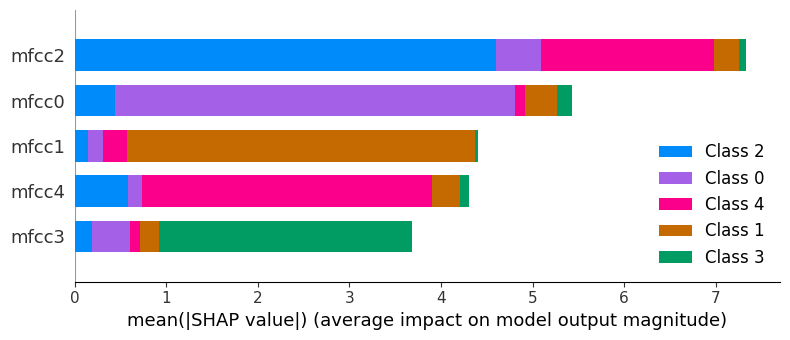

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_df)
shap.summary_plot(shap_values, train_feat_df)

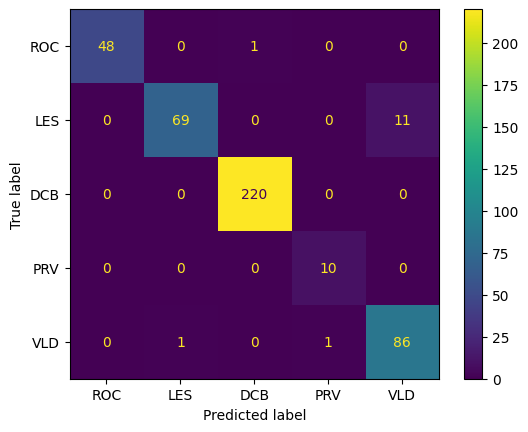

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

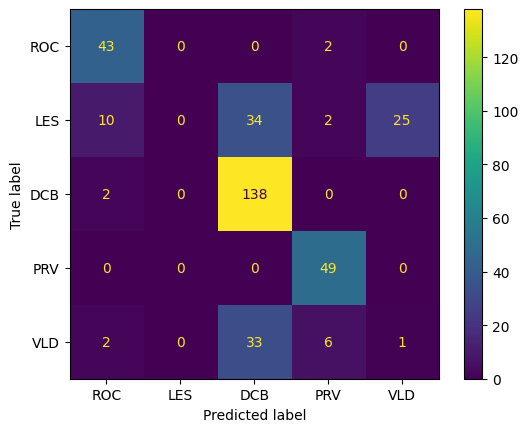

In [ ]:

confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()